In [1]:
import xgboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = 'RF_YN_Model3.csv'
df = pd.read_csv(data)
df.head()

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Displ (m),Target
0,0.370809,0.909116,0.319117,5.465739,0.546270,0.000000,0
1,1.300896,1.123009,0.211770,0.905948,0.532398,0.195432,0
2,1.300896,0.847858,0.195947,0.849104,0.532398,0.217259,0
3,1.788212,2.044325,0.115795,0.451034,0.542307,0.239763,0
4,1.637517,2.003797,0.137265,0.941866,0.545784,0.377358,1


In [3]:
#define features matrix (X) and target (y)
X = df.drop(['Displ (m)'], axis = 1)
y = df.drop(['GWD (m)', 'Elevation',  'L (km)', 'Slope (%)','PGA (g)','Displ (m)'],axis=1)

# implementing train-test-split
X_train_target, X_test_target, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_all = X.drop(['Target'], axis=1)
X_train = X_train_target.drop(['Target'], axis = 1)
X_test = X_test_target.drop(['Target'], axis = 1)


In [4]:
# Classifier fit
model = xgboost.XGBClassifier(use_label_encoder=False).fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Representer learning with sklearn Decision Trees

Create a list of predictions based on `X_train` to learn what the model learnt.

In [5]:
predictions = model.predict(X_train)

In [6]:
# Create a reference tree from sklearn and plot
clftree = tree.DecisionTreeClassifier()
clftree.fit(X_train, predictions)


DecisionTreeClassifier()

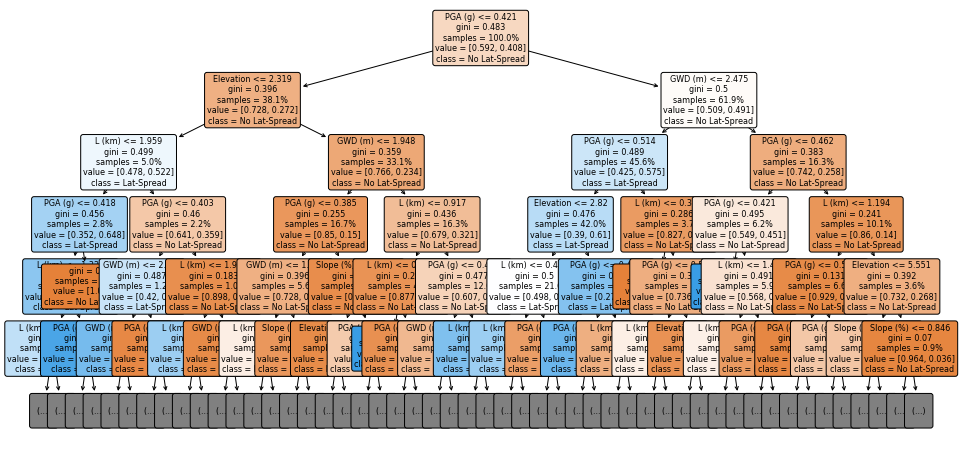

In [7]:
indices = np.array(['GWD (m)', 'Elevation', 'L (km)', 'Slope (%)', 'PGA (g)'])
fig = plt.figure(figsize=(16, 8))
vis = tree.plot_tree(clftree, feature_names=indices, class_names=['No Lat-Spread', 'Lat-Spread'], max_depth=5, fontsize=8, proportion=True, filled=True, rounded=True)

In [8]:
dotfile = open("dtree.dot", 'w')
tree.export_graphviz(clftree, out_file = dotfile, feature_names = indices,  proportion=True, filled=True, rounded=True)
dotfile.close()

## Representer tree with XGBoost

In [9]:
xgclf = xgboost.XGBClassifier(use_label_encoder=False)
xgclf.fit(X_train, predictions)

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

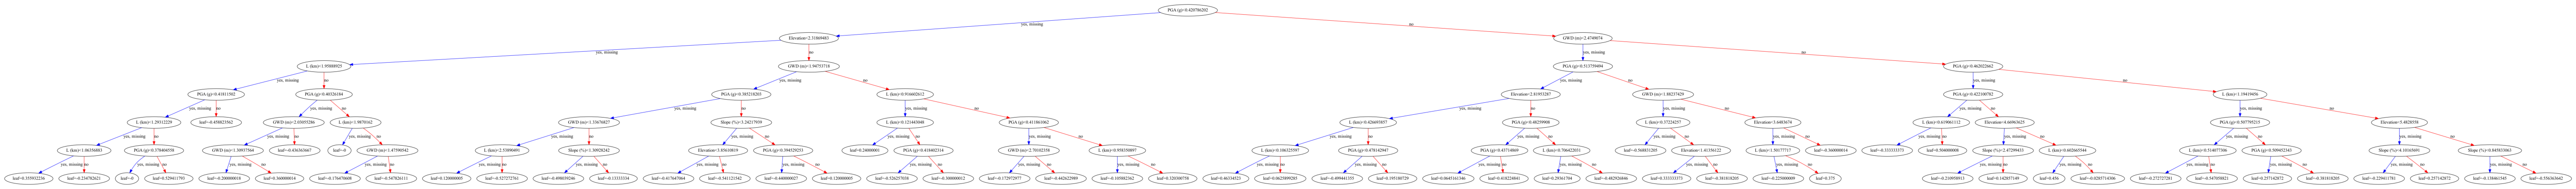

In [18]:
xgboost.plot_tree(xgclf)
plt.gcf().set_size_inches(100, 40)
plt.savefig("xgb-class.svg")

For a classification tree with 2 classes {0,1}, the value of the leaf node represent the raw score for class 1. It can be converted to a probability score by using the logistic function. The calculation below use the left most leaf as an example. The value of first leaf node is 0.35593, so the conditional probability of class 1 prediction is 0.588 or 59%.

$$1/(1+np.exp(-1*0.35593))=0.5880548460169396$$